### Geographic Plotting of Inference Results

This notebook performs the following: 
- re-loads the results from an aspect-based emotion analysis
- turns the df into a geo-df using geopandas
- plots a (basic) heatmap of the 4 emotions: happiness, anger, fear, sadness
- identifies the main words in that are targets of happiness, anger, fear, and sadness and plots their spatial occurence along with the emotion

### Setup

In [38]:
# ----------------------------------------------
# General data science packages

import pandas as pd                                                             # Data handling
import numpy as np                                                              # Fundamental package for array computing in pythonimport csv
import matplotlib.pyplot as plt                                                 # A python plotting package
%matplotlib inline 
import matplotlib.ticker as ticker                                              # Provides classes for configuring tick locating and formatting
from matplotlib.ticker import MaxNLocator, FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import seaborn as sns; sns.set(style="ticks", color_codes=True)                 # Statistical data visualization
import contextily                                                               # Context geo-tiles in Python                                                               
import plotly                                                                   # An open-source interactive data visualisation library
import plotly.express as px                                                     # for interactive, animated timeseries map
import seaborn as sns; sns.set(style="ticks", color_codes=True)                 # A statistical data visualisation toolimport random
import argparse
import random
from datetime import datetime, timedelta
import time                                                                     # used for adding a break in between the processing of data chunks
import math      
import urllib.request                                                           # Functions for opening URLs


# ----------------------------------------------
# Import the required GRACE files from the folders

import sys
import os


# ----------------------------------------------
# Geographic/ spatial packages

import geopandas as gpd                                                         # Geographic data handling
import folium                                                                   # Interactive mapping capabilities
import folium.plugins as plugins                                                # Interactive mapping capabilities
from shapely.geometry import Point, Polygon, shape                              # Creating geospatial data
from shapely import wkb, wkt                                                    # Creating and parsing geospatial data
from shapely.wkb import loads
import shapely                                                                  # Creating and parsing geospatial data
import contextily as ctx

# ----------------------------------------------
# A few other packages
from wordcloud import WordCloud                                                 # A wordcloud generator
from wordcloud import ImageColorGenerator                                       # A wordcloud generator
from wordcloud import STOPWORDS                                                 # A wordcloud generator
from PIL import Image                                                           # For masking wordcloud with an image
import requests                                                                 # For accessing url images
from io import BytesIO                                                          # For accessing url images

from collections import Counter
import re

from collections import Counter
from nltk.corpus import stopwords
import nltk

### Reload CSV of ABEA Results

In [39]:
df= pd.read_csv("Data/Case Study Data/abea_results_all.csv")
print(f"Loaded ABEA df, length is: {len(df)}")
df.sample(5)

Loaded ABEA df, length is: 27055140


,Unnamed: 0,message_id,date,text,geom,geometry,geom_type,area_sq_miles,aspect_terms,aspect_emotions
26424795,26424795,1300136011662385152,2020-08-30 18:19:15,@tracktalkradio @CClevelandMusic @MissTacTalk ...,0103000020E6100000010000000500000086ADD9CA4B6E...,POLYGON ((-150829.59371522162 15986.4770343014...,Polygon,8.844336,['SUPPORT'],['HAPPINESS']
10661026,10661026,1276681232026222592,2020-06-27 00:58:19,@INadtochey @KabanMadan Да нет это не смех они...,0103000020E610000001000000050000005DA96741285B...,POLYGON ((-123840.17428984321 70072.0517177553...,Polygon,21.832428,[],[]
22247934,22247934,1263331718255136768,2020-05-21 04:52:07,@PDinCanada None of them is being honest about...,0103000020E610000001000000050000000C772E8CF4A0...,POLYGON ((-221388.7279698656 -31335.3041264326...,Polygon,74.616853,[],[]
983956,983956,1335540929113989122,2020-12-06 11:05:45,Early bird gets the worm 💰💰💰,0103000020E6100000010000000500000073D53C47E49C...,POLYGON ((143209.94991853807 -454307.737801045...,Polygon,14.405018,['Early bird'],['HAPPINESS HAPPINESS']
4542703,4542703,1288137822054961153,2020-07-28 15:42:43,Join or Renew The Friends of the Covina Public...,0103000020E6100000010000000500000021EA3E00A976...,POLYGON ((198074.80507186468 -436855.479868981...,Polygon,26.353369,[],[]


In [40]:
df_1 = df.drop(columns=['geom', 'area_sq_miles'])

# Convert the 'geometry' column from WKT to shapely geometries
df_1['geometry'] = df_1['geometry'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(df_1, geometry='geometry', crs='EPSG:4326')

gdf_points = gdf.copy()


# Iterate over each row in the geodataframe using a for-loop
for index, row in gdf_points.iterrows():

    # If-condition to check if the row['geom_type'] is a Polygon
    if row['geom_type'] == 'Polygon':

        # Get the centroid of the polygon
        centroid = row['geometry'].centroid

        # Create a new Point geometry from the centroid
        gdf_points.at[index, 'geometry'] = centroid

        # Update the geom_type of the row to 'Point'
        row['geom_type'] = 'Point'

# Check the geometry types again to make sure we successfully converted all polygons to points
print(f"Loaded the plain df as df_1. Loaded into gdf with points and polygons as gdf. Loaded into centroids only gdf as gdf_points.")
print(gdf_points.geom_type.value_counts())

Loaded the plain df as df_1. Loaded into gdf with points and polygons as gdf. Loaded into centroids only gdf as gdf_points.
Point    27055140
Name: count, dtype: int64


In [41]:
# create columns for latitude and longitude
gdf_points['lat'] = gdf_points['geometry'].apply(lambda x : x.y if x else np.nan)
gdf_points['lon'] = gdf_points['geometry'].apply(lambda x : x.x if x else np.nan)

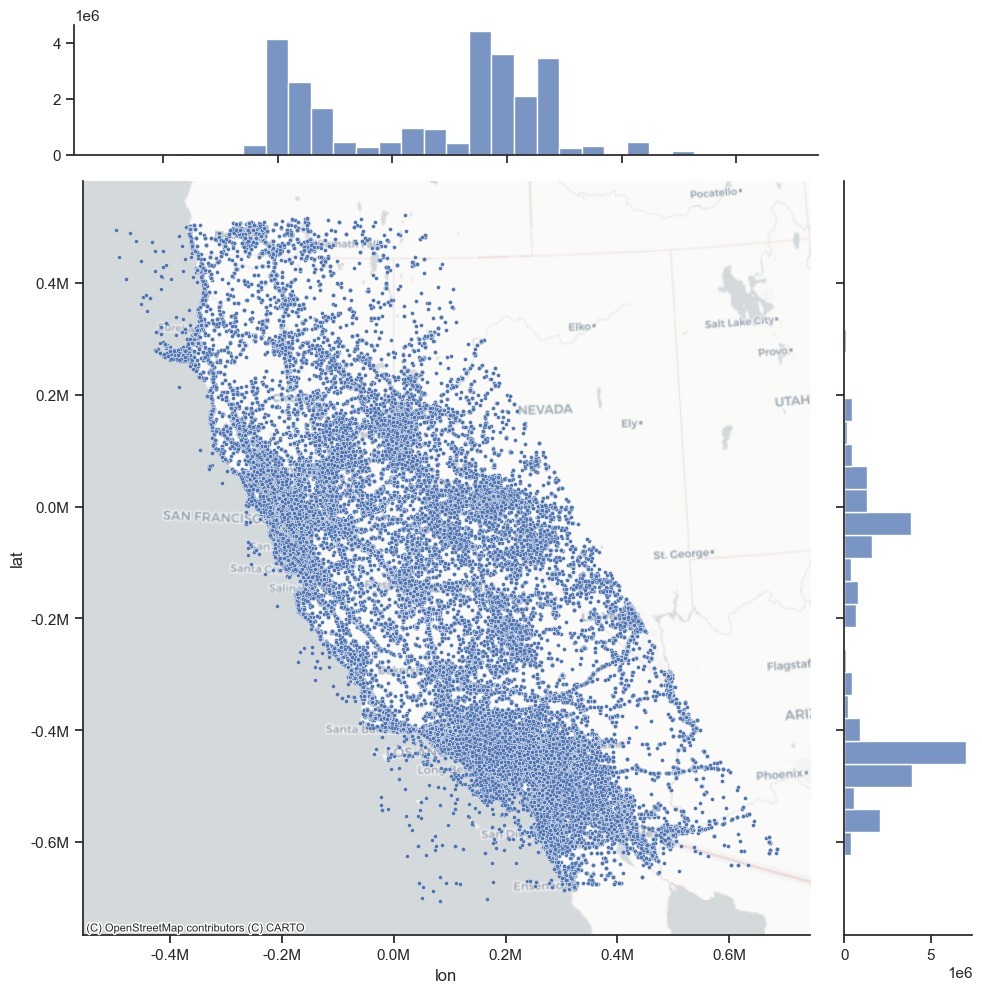

In [42]:
# Function to format numbers in millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


# Generate a jointplot with a base map to show spatial distribution
joint_axes = sns.jointplot(
    x=gdf_points["lon"], # specify the longitude column of the dataset
    y=gdf_points["lat"], # specify the latitude column of the dataset
    data=df, # specify the dataset to be plotted
    s=8,
    height=10, # Increased height for a larger plot
    ratio=5,  # ratio controls size of the bar charts on top and right
    marginal_ticks=True, # specify the size of the point markers (in numeric terms, e.g. 3)
    marginal_kws=dict(bins=30) # Increase the number of bins
)

formatter = FuncFormatter(millions)
joint_axes.ax_marg_x.xaxis.set_major_formatter(formatter)
joint_axes.ax_marg_y.yaxis.set_major_formatter(formatter)

contextily.add_basemap(
    joint_axes.ax_joint, # join the basemap with the plot
    crs='EPSG:3310', # specify the coordinate reference system (should be the same as your data)
    source=contextily.providers.CartoDB.Positron # the style of the base map (but you can change it if you like)
)


In [43]:
gdf_points.head()

,Unnamed: 0,message_id,date,text,geometry,geom_type,aspect_terms,aspect_emotions,lat,lon
0,0,1333561451320061953,2020-12-01 00:00:01,@krystal.jordan_ #fitness #workout #clubdress ...,POINT (162056.36445 -438410.07956),Point,[],[],-438410.079556,162056.364451
1,1,1333561453605834752,2020-12-01 00:00:01,@willw your matrix thread confused me so much....,POINT (151979.32734 -471605.25228),Polygon,['your matrix thread'],['SADNESS SADNESS SADNESS'],-471605.252277,151979.327340
2,2,1333561456525078529,2020-12-01 00:00:02,@edukatdedukater I was disappointed 😞,POINT (170692.66580 -465670.46401),Polygon,[],[],-465670.464005,170692.665801
3,3,1333561465211547648,2020-12-01 00:00:04,"Nervous to apply for a job like ""Seasonal Pers...",POINT (186175.50512 -436913.78268),Point,[],[],-436913.782680,186175.505121
4,4,1333561466247540736,2020-12-01 00:00:04,The cool thing about the e dirt bike is since ...,POINT (70967.46892 -413737.36979),Polygon,['e dirt bike'],['HAPPINESS HAPPINESS HAPPINESS'],-413737.369789,70967.468916


### Filter for Fire Overlaps

In [44]:
# Load wildfire GeoJSON into gdf
wildfires_gdf = gpd.read_file('Data/Case Study Data/top_10_fires.geojson')
print('Loaded the wildfire dataset into a gdf.')

# Inspect the date columns to understand their format
wildfires_gdf[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE']].head()

Loaded the wildfire dataset into a gdf.


,FIRE_NAME,ALARM_DATE,CONT_DATE
0,CZU LIGHTNING COMPLEX,1597536000000,1.600906e+12
1,SILVERADO,1603670400000,1.604275e+12
2,BLUE RIDGE,1603670400000,1.604275e+12
3,BOND,1606953600000,1.607299e+12
4,MOC,1597881600000,1.599264e+12


In [45]:
# Convert Unix timestamps to datetime
wildfires_gdf['ALARM_DATE'] = pd.to_datetime(wildfires_gdf['ALARM_DATE'], unit='ms')
wildfires_gdf['CONT_DATE'] = pd.to_datetime(wildfires_gdf['CONT_DATE'], unit='ms')

# Verify the date conversion
wildfires_gdf[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE']].head()


,FIRE_NAME,ALARM_DATE,CONT_DATE
0,CZU LIGHTNING COMPLEX,2020-08-16,2020-09-24
1,SILVERADO,2020-10-26,2020-11-02
2,BLUE RIDGE,2020-10-26,2020-11-02
3,BOND,2020-12-03,2020-12-07
4,MOC,2020-08-20,2020-09-05


In [46]:
# Set the CRS for wildfire data to EPSG:4326
wildfires_gdf = wildfires_gdf.set_crs(epsg=4326, allow_override=True)
print(f'Wildfire CRS now: {wildfires_gdf.crs}')


# Set the CRS for points data to EPSG:3310
gdf_points = gdf_points.set_crs(epsg=3310, allow_override=True)
print(f'GDF for the tweets CRS now: {gdf_points.crs}')


# Reproject wildfire data to EPSG:3310
wildfires_gdf = wildfires_gdf.to_crs(epsg=3310)
print(f'Wildfire CRS after reprojecting: {wildfires_gdf.crs}')



Wildfire CRS now: EPSG:4326
GDF for the tweets CRS now: EPSG:3310
Wildfire CRS after reprojecting: EPSG:3310


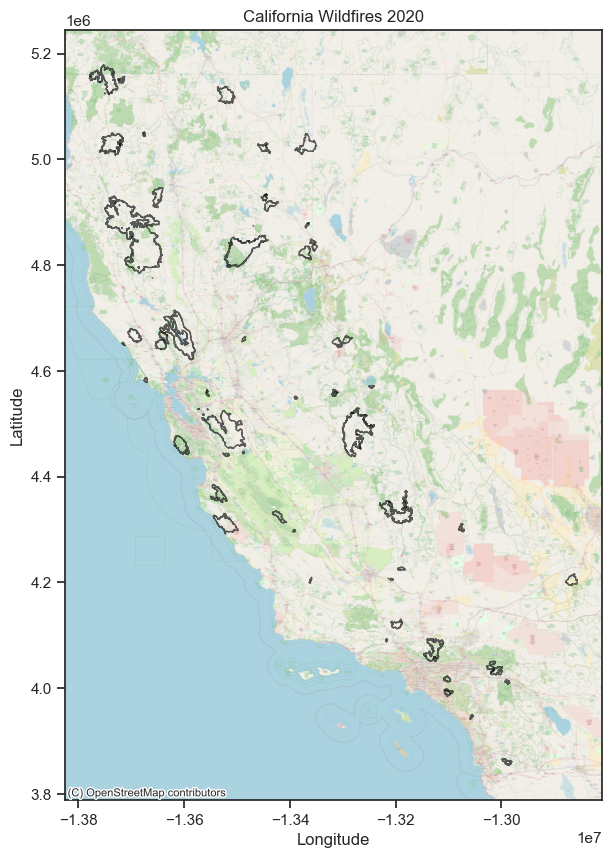

In [47]:
# check that the fires are loaded correctly

wildfires_copy_gdf = wildfires_gdf.copy()

# Convert the CRS to EPSG:3857 for plotting with basemap
wildfires_copy_gdf = wildfires_copy_gdf.to_crs(epsg=3857)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
wildfires_copy_gdf.plot(ax=ax, edgecolor='k', facecolor='none', alpha=0.7)

# Optionally add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

# Set plot title and labels
plt.title('California Wildfires 2020')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()

In [48]:
# buffer distance in meters (30000 meters = 30 km)
buffer_distance = 30000

# Convert the date column to datetime in the tweets GeoDataFrame
gdf_points['date'] = pd.to_datetime(gdf_points['date'])

# empty GeoDataFrame to hold results
tweets_intersecting_fires_gdf = gpd.GeoDataFrame(columns=gdf_points.columns, crs=gdf_points.crs)

# new col for fire name in the resulting gdf (will make subset stats later on easier)
tweets_intersecting_fires_gdf['FIRE_NAME'] = None

# iterate through each wildfire to find overlaps in time and space with the twitter data
for _, fire in wildfires_gdf.iterrows():
    fire_polygon = fire.geometry
    containment_date = pd.to_datetime(fire['CONT_DATE'])
    alarm_date = pd.to_datetime(fire['ALARM_DATE'])
    fire_name = fire['FIRE_NAME']
    print(f"Searching for tweets related to the {fire['FIRE_NAME']} fire.\nStarted: {alarm_date}\nContained: {containment_date}")

    # Skip if dates are NaT (Not a Time)
    if pd.isna(alarm_date) or pd.isna(containment_date):
        continue

    # Set a buffer around the fire polygon
    fire_buffer = fire_polygon.buffer(buffer_distance)
    
    # Filter tweets based on the date criteria
    date_mask = (gdf_points['date'] >= alarm_date) & (gdf_points['date'] <= containment_date + timedelta(days=14))
    tweets_in_time = gdf_points[date_mask]
    
    # Filter tweets based on the location criteria (within the fire bounds or buffer)
    spatial_mask = tweets_in_time.intersects(fire_polygon) | tweets_in_time.intersects(fire_buffer)
    tweets_in_space = tweets_in_time[spatial_mask]

    # Add the fire name to the filtered tweets
    tweets_in_space['FIRE_NAME'] = fire_name
    
    # Append the filtered tweets to the result GeoDataFrame
    tweets_intersecting_fires_gdf = pd.concat([tweets_intersecting_fires_gdf, tweets_in_space])


# Reset the index of the result GeoDataFrame
tweets_intersecting_fires_gdf = tweets_intersecting_fires_gdf.reset_index(drop=True)

print(f"The twitter subset for fire overlap in time and space: {len(tweets_intersecting_fires_gdf)}")

Searching for tweets related to the CZU LIGHTNING COMPLEX fire.
Started: 2020-08-16 00:00:00
Contained: 2020-09-24 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\chris\AppData\Local\Temp\ipykernel_13764\2708961527.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tweets_intersecting_fires_gdf = pd.concat([tweets_intersecting_fires_gdf, tweets_in_space])


Searching for tweets related to the SILVERADO fire.
Started: 2020-10-26 00:00:00
Contained: 2020-11-02 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BLUE RIDGE fire.
Started: 2020-10-26 00:00:00
Contained: 2020-11-02 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BOND fire.
Started: 2020-12-03 00:00:00
Contained: 2020-12-07 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the MOC fire.
Started: 2020-08-20 00:00:00
Contained: 2020-09-05 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BENA fire.
Started: 2020-07-01 00:00:00
Contained: 2020-07-05 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the STAGECOACH fire.
Started: 2020-08-03 00:00:00
Contained: 2020-08-03 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the PASS fire.
Started: 2020-06-28 00:00:00
Contained: 2020-07-01 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BRANCH fire.
Started: 2020-07-28 00:00:00
Contained: 2020-08-03 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the ZOGG fire.
Started: 2020-09-27 00:00:00
Contained: 2020-10-13 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the GRANT FIRE fire.
Started: 2020-06-12 00:00:00
Contained: 2020-06-12 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the HILLS fire.
Started: 2020-08-15 00:00:00
Contained: 2020-09-27 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the MINERAL fire.
Started: 2020-07-13 00:00:00
Contained: 2020-07-26 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the CARMEL fire.
Started: 2020-08-18 00:00:00
Contained: 2020-09-06 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the RIVER fire.
Started: 2020-08-16 00:00:00
Contained: 2020-09-04 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the HOLSER fire.
Started: 2020-08-17 00:00:00
Contained: 2020-08-22 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the SCU COMPLEX fire.
Started: 2020-08-16 00:00:00
Contained: 2020-09-11 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the CREWS fire.
Started: 2020-07-05 00:00:00
Contained: 2020-07-15 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BOBCAT fire.
Started: 2020-09-06 00:00:00
Contained: 2020-10-19 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the MEYERS fire.
Started: 2020-08-17 00:00:00
Contained: 2020-09-02 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the WALBRIDGE fire.
Started: 2020-08-17 00:00:00
Contained: 2020-09-11 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the HENNESSEY fire.
Started: 2020-08-17 00:00:00
Contained: 2020-09-16 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the GLASS fire.
Started: 2020-09-27 00:00:00
Contained: 2020-10-20 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BEACH fire.
Started: 2020-08-16 00:00:00
Contained: 2020-08-27 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the LOYALTON fire.
Started: 2020-08-14 00:00:00
Contained: 2020-08-27 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the SHEEP fire.
Started: 2020-08-17 00:00:00
Contained: 2020-09-07 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the DOLAN fire.
Started: 2020-08-18 00:00:00
Contained: 2020-12-31 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the FOX fire.
Started: 2020-09-14 00:00:00
Contained: 2020-09-28 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the NORTH COMPLEX fire.
Started: 2020-08-17 00:00:00
Contained: 2020-12-03 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the CASTLE fire.
Started: 2020-08-19 00:00:00
Contained: 2021-01-04 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the CREEK fire.
Started: 2020-09-04 00:00:00
Contained: 2020-12-24 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the DEVIL fire.
Started: 2020-09-09 00:00:00
Contained: NaT
Searching for tweets related to the SLATER fire.
Started: 2020-09-08 00:00:00
Contained: 2020-12-12 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the LAKE fire.
Started: 2020-08-12 00:00:00
Contained: 2020-08-30 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the RANCH2 fire.
Started: 2020-08-13 00:00:00
Contained: 2020-10-01 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the VALLEY fire.
Started: 2020-09-05 00:00:00
Contained: 2020-09-24 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the SNOW fire.
Started: 2020-09-17 00:00:00
Contained: 2020-09-24 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the AUGUST COMPLEX fire.
Started: 2020-08-16 00:00:00
Contained: 2020-11-11 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the HOG fire.
Started: 2020-07-18 00:00:00
Contained: 2020-08-28 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the RED SALMON COMPLEX fire.
Started: 2020-07-27 00:00:00
Contained: 2020-11-19 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BLUEJAY fire.
Started: 2020-07-25 00:00:00
Contained: 2020-11-19 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the CALDWELL fire.
Started: 2020-07-22 00:00:00
Contained: 2020-09-01 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the DOME fire.
Started: 2020-08-15 00:00:00
Contained: 2020-09-12 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the RATTLESNAKE fire.
Started: 2020-08-16 00:00:00
Contained: 2020-12-28 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the WOLF fire.
Started: 2020-08-10 00:00:00
Contained: 2020-11-19 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the WOODWARD fire.
Started: 2020-08-18 00:00:00
Contained: 2020-11-20 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the BACCARAT fire.
Started: 2020-10-04 00:00:00
Contained: 2020-10-11 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the LAURA 2 fire.
Started: 2020-11-17 00:00:00
Contained: 2020-11-23 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the MOUNTAIN VIEW fire.
Started: 2020-11-17 00:00:00
Contained: 2020-11-30 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the NADEAU fire.
Started: 2020-07-29 00:00:00
Contained: 2020-08-04 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the NORTH fire.
Started: 2020-08-02 00:00:00
Contained: 2020-08-10 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the SLINK fire.
Started: 2020-08-29 00:00:00
Contained: 2020-11-13 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the W-5 COLD SPRINGS fire.
Started: 2020-08-18 00:00:00
Contained: 2020-09-13 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the CREEK 5 fire.
Started: 2021-12-30 00:00:00
Contained: 2021-12-31 00:00:00
Searching for tweets related to the EL DORADO fire.
Started: 2020-09-05 00:00:00
Contained: 2020-11-16 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the GOLD fire.
Started: 2020-07-20 00:00:00
Contained: 2020-10-29 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Searching for tweets related to the APPLE fire.
Started: 2020-07-31 00:00:00
Contained: 2020-11-15 00:00:00


c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


The twitter subset for fire overlap in time and space: 3617722


In [49]:
# Convert datetime fields to strings
tweets_intersecting_fires_gdf['date'] = tweets_intersecting_fires_gdf['date'].astype(str)

# Save the result to a new Shapefile
tweets_intersecting_fires_gdf.to_file('Data/Case Study Data/tweets_intersecting_fires.geojson', driver='GeoJSON')


In [50]:
print(len(tweets_intersecting_fires_gdf))

3617722


In [ ]:
tweets_intersecting_fires_gdf.head()

checking to see if the locations of the points are ok

In [35]:
# create columns for latitude and longitude
tweets_intersecting_fires_gdf['lat'] = tweets_intersecting_fires_gdf['geometry'].apply(lambda x : x.y if x else np.nan)
tweets_intersecting_fires_gdf['lon'] = tweets_intersecting_fires_gdf['geometry'].apply(lambda x : x.x if x else np.nan)

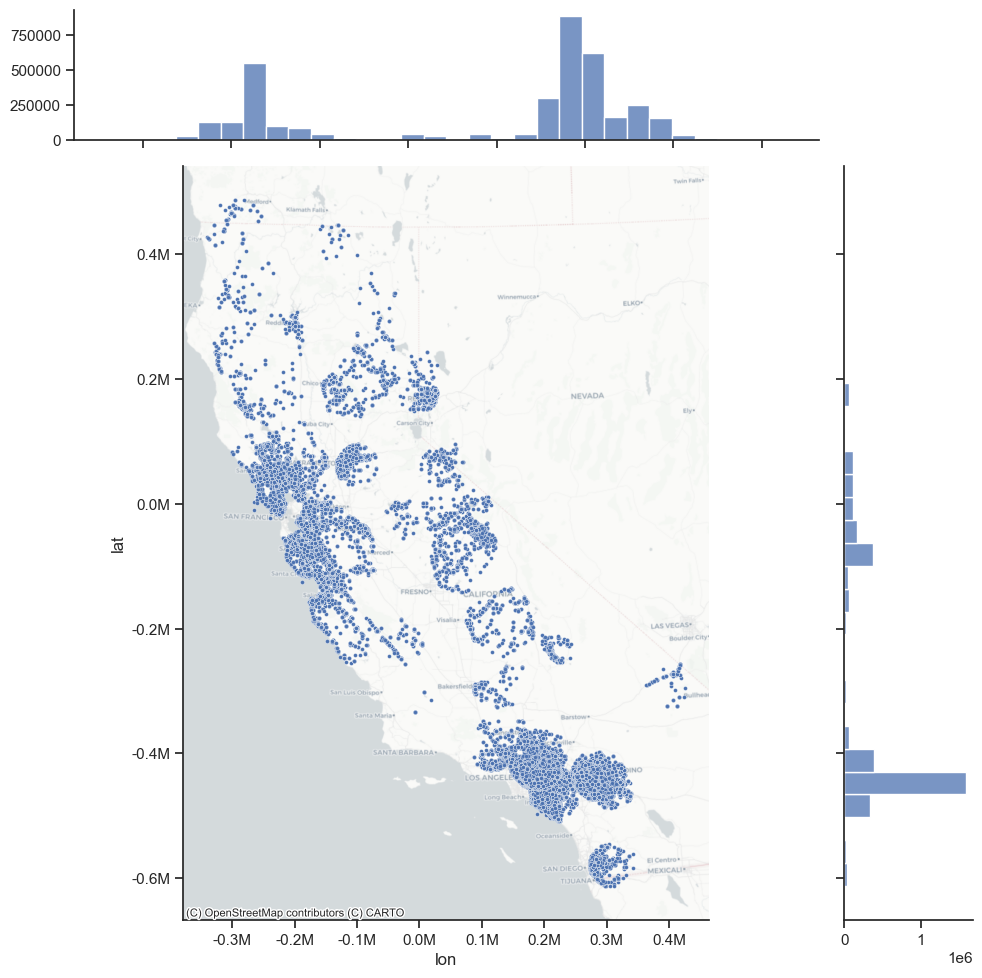

In [36]:
# Function to format numbers in millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)


# Generate a jointplot with a base map to show spatial distribution
joint_axes = sns.jointplot(
    x=tweets_intersecting_fires_gdf["lon"], # specify the longitude column of the dataset
    y=tweets_intersecting_fires_gdf["lat"], # specify the latitude column of the dataset
    data=df, # specify the dataset to be plotted
    s=8,
    height=10, # Increased height for a larger plot
    ratio=5,  # ratio controls size of the bar charts on top and right
    marginal_ticks=True, # specify the size of the point markers (in numeric terms, e.g. 3)
    marginal_kws=dict(bins=30) # Increase the number of bins
)

formatter = FuncFormatter(millions)
joint_axes.ax_marg_x.xaxis.set_major_formatter(formatter)
joint_axes.ax_marg_y.yaxis.set_major_formatter(formatter)

contextily.add_basemap(
    joint_axes.ax_joint, # join the basemap with the plot
    crs='EPSG:3310', # specify the coordinate reference system (should be the same as your data)
    source=contextily.providers.CartoDB.Positron # the style of the base map (but you can change it if you like)
)


### Stats on Emotions and Aspect Terms per Fire

- doughnut piechart showing the emotion distribution per fire
- the top non-stopword aspect terms per emotion per fire

In [ ]:
# get subset for one of the fires


#### Split Aspect Terms into Indiviual Rows 

In [37]:
# split aspect terms into individual rows 

def expand_aspect_terms(df):
    df['aspect_terms'] = df['aspect_terms'].apply(lambda x: eval(x) if isinstance(x, str) else x)
    df['aspect_emotions'] = df['aspect_emotions'].apply(lambda x: eval(x) if isinstance(x, str) else x)

    # Explode the 'aspect_terms' and 'aspect_emotions' columns into separate rows
    df_exploded = df.explode('aspect_terms')
    df_exploded = df_exploded.explode('aspect_emotions')

    # Aligning the 'aspect_emotions' with 'aspect_terms' in cases of mismatched lengths
    # It will duplicate emotions if there are fewer emotions than terms
    df_exploded['aspect_emotions'] = df_exploded.groupby(['message_id'])['aspect_emotions'].transform(lambda x: x.ffill().bfill())

    # Replace NaN with "-"
    df_exploded['aspect_terms'].fillna('-', inplace=True)
    df_exploded['aspect_emotions'].fillna('-', inplace=True)

    return df_exploded


tweets_intersecting_fires_gdf_expanded = expand_aspect_terms(tweets_intersecting_fires_gdf)
print(len(tweets_intersecting_fires_gdf_expanded))
tweets_intersecting_fires_gdf_expanded.head(10)

KeyboardInterrupt: 

#### Piecharts for the Emotions for Each Fire

In [ ]:
# get the fire names
fire_names = tweets_intersecting_fires_gdf['FIRE_NAME'].unique()
print(fire_names)

In [ ]:
# function to plot the doughnut-style pie chart for the emotion distribution of each fire
def plot_emotion_distribution(emotion_counts, fire_name, save_path):
    labels = emotion_counts.index
    sizes = emotion_counts.values
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, colors=colors, startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    
    # Draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal')  
    plt.title(f'Emotion Distribution for {fire_name}')
    plt.tight_layout()
    plt.show()

    # Save the plot as a PNG file
    plt.savefig(save_path, format='png')
    plt.close()



In [ ]:
# place to save the png piechart figures
save_image_dir = 'Data/Case Study Data/Stats Per Fire'

# iterate over each fire and to create a pie chart
for fire_name in fire_names:
    fire_subset = tweets_intersecting_fires_gdf[tweets_intersecting_fires_gdf['FIRE_NAME'] == fire_name]
    emotion_counts = fire_subset['aspect_emotions'].value_counts()

    save_path = os.path.join(save_image_dir, f'{fire_name}_emotion_distribution.png')
    
    plot_emotion_distribution(emotion_counts, fire_name)

In [ ]:
tweets_intersecting_fires_gdf_expanded.to_file('Data/Case Study Data/tweets_intersecting_fires_expanded.geojson', driver='GeoJSON')

#### Top Aspect Terms Per Emotion Per Fire

In [ ]:
# Filter the expanded df to create subsets for each emotion
df_happiness = expanded_df[expanded_df['aspect_emotions'] == 'HAPPINESS']
df_anger = expanded_df[expanded_df['aspect_emotions'] == 'ANGER']
df_fear = expanded_df[expanded_df['aspect_emotions'] == 'FEAR']
df_sadness = expanded_df[expanded_df['aspect_emotions'] == 'SADNESS']

print(f"Happiness: {len(df_happiness)}")
print(f"Fear: {len(df_fear)}")
print(f"Sadness: {len(df_sadness)}")
print(f"Anger: {len(df_anger)}")


Happiness: 20974
Fear: 6024
Sadness: 12551
Anger: 3700


### Find most common Non-Stopwords for each Emotion

In [ ]:
# Download the list of stopwords
nltk.download('stopwords')

def most_common_words(text_series):
    # Define English stop words
    stop_words = set(stopwords.words('english'))
    
    # Initialize a Counter object
    word_count = Counter()
    
    # Iterate through each text entry
    for text in text_series:
        # Tokenize the text into words and filter out stop words
        words = [word.lower() for word in text.split() if word.lower() not in stop_words]
        # Update the Counter object
        word_count.update(words)
    
    # Return the 20 most common words
    return word_count.most_common(20)

common_words_happiness = most_common_words(df_happiness['text'])
common_words_anger = most_common_words(df_anger['text'])
common_words_fear = most_common_words(df_fear['text'])
common_words_sadness = most_common_words(df_sadness['text'])

print(f"Most Common words for Happiness: {common_words_happiness}")
print(f"Most Common words for Anger: {common_words_anger}")
print(f"Most Common words for Fear: {common_words_fear}")
print(f"Most Common words for Sadness: {common_words_sadness}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most Common words for Happiness: [('thank', 2511), ('love', 2335), ('get', 1675), ('like', 1460), ('&', 1313), ('good', 1165), ('i’m', 1133), ('one', 1018), ('it’s', 959), ('happy', 924), ('great', 903), ('u', 873), ('know', 818), ('much', 806), ('really', 759), ('hit.', 729), ('see', 727), ('@realdonaldtrump', 707), ('people', 696), ('time', 680)]
Most Common words for Anger: [('like', 568), ('people', 398), ('get', 393), ('don’t', 344), ('you’re', 313), ('it’s', 290), ('shit', 245), ('know', 237), ('@realdonaldtrump', 235), ('one', 228), ('fucking', 225), ('i’m', 217), ('go', 205), ('can’t', 204), ('that’s', 203), ('&', 197), ('even', 195), ('fuck', 165), ('say', 151), ('make', 148)]
Most Common words for Fear: [('like', 692), ('get', 595), ('people', 505), ('&', 405), ('it’s', 403), ('i’m', 378), ('one', 377), ('going', 346), ('trump', 337), ('don’t', 319), ('know', 319), ('need', 316), ('even', 299), ('would', 299), ('think', 279), ('see', 272), ('got', 259), ('still', 255), ('go',

### Filter for Target Words in the Aspect Terms and Plot 

In [16]:
def filter_and_map(df, keywords, output_shapefile_path):
    # Filter the DataFrame for rows where 'aspect_terms' intersects with 'keywords'
    df_filtered = df[df['aspect_terms'].apply(lambda x: any(k in x for k in keywords))]

    if df_filtered.empty:
        print("No data found for the specified keywords.")
        return None

    try:
        # Convert the 'geom' column from WKB to a GeoSeries
        df_filtered['geometry'] = df_filtered['geometry'].apply(wkt.loads)
    except Exception as e:
        print(f"Failed to convert geometry data: {e}")
        return None

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df_filtered, geometry='geometry', crs='EPSG:4326')

    # Check if GeoDataFrame is empty or has invalid geometries
    if gdf.empty or not gdf['geometry'].is_valid.all():
        print("Invalid or no geometries to plot.")
        return None

    # Calculate the centroid for each row's geometry
    gdf_centroids = gdf.copy()
    gdf_centroids['geometry'] = gdf['geometry'].centroid
    gdf_centroids =gdf_centroids[['message_id', 'date', 'text', 'geometry', 'aspect_terms', 'aspect_emotions']]

    # Export to Shapefile
    gdf_centroids.to_file(output_shapefile_path)

    return gdf



# Define keywords and colors for each emotion
keywords = ['love', 'burn', 'disaster']
joined_keywords = '_'.join(keywords)
emotion = ['happiness', 'anger', 'sadness', 'fear']
output_shapefile_path = f'Data/Case Study Data/{emotion[0]}_{joined_keywords}.shp'  # Example for happiness

# Apply the function to the happiness DataFrame
gdf_happiness = filter_and_map(df_happiness, keywords, output_shapefile_path)




Index(['message_id', 'date', 'text', 'geometry', 'aspect_terms',
       'aspect_emotions'],
      dtype='object')


C:\Users\chris\AppData\Local\Temp\ipykernel_17224\3979346651.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['geometry'] = df_filtered['geom'].apply(lambda x: wkb.loads(x, hex=True))
C:\Users\chris\AppData\Local\Temp\ipykernel_17224\3979346651.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_centroids['geometry'] = gdf['geometry'].centroid
C:\Users\chris\AppData\Local\Temp\ipykernel_17224\3979346651.py:32: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_centroids.to_file(output_shapefile_path)
